# <p style="padding: 15px; background-color: #101B37; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #F2F2F0; letter-spacing: 2px; text-align: center; border-radius: 8px;">Playground Series S3E12</p>

In [273]:
# %load ../initial_settings.py
import os
import shutil
import subprocess
import sys
from pathlib import Path
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from colorama import Fore, Style
from IPython.display import display_html
from IPython.core.display import HTML
from matplotlib.patches import PathPatch
from plotly.subplots import make_subplots

from scipy.stats import probplot
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

# =============================================================================
# Indicates whether the notebook is running on Kaggle or not.
ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None

# Here we store models if these are interesting.
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(exist_ok=True)  # If directory exists, do nothing.

CLR = (Style.BRIGHT + Fore.BLACK) if ON_KAGGLE else (Style.BRIGHT + Fore.WHITE)
RED = Style.BRIGHT + Fore.RED
BLUE = Style.BRIGHT + Fore.BLUE
CYAN = Style.BRIGHT + Fore.CYAN
RESET = Style.RESET_ALL

# Matplotlib & Seaborn settings.
FONT_COLOR = "#101B37"
BACKGROUND_COLOR = "#F6F5F5"
DF_CMAP = sns.light_palette("#101B37", as_cmap=True)
MY_RC = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": 10,
    "axes.labelpad": 15,
    "axes.labelweight": "bold",
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.titlepad": 15,
    "axes.facecolor": BACKGROUND_COLOR,
    "xtick.labelsize": 10,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": 10,
    "ytick.color": FONT_COLOR,
    "figure.titlesize": 14,
    "figure.titleweight": "bold",
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "font.size": 10,
    "font.family": "Serif",
    "text.color": FONT_COLOR,
}

sns.set_theme(rc=MY_RC)

DF_PROPS = {
    "background-color": "#101B37",
    "color": "#D4D0A9",
    "border": "1.5px solid #D4D0A9",
}

# =============================================================================
# Utility functions.
def download_from_kaggle(competition):
    command = "kaggle competitions download -c "
    filepath = Path("data/" + competition + ".zip")

    if not filepath.is_file():
        subprocess.run((command + competition).split())
        Path("data").mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(competition + ".zip", "data")
        shutil.move(competition + ".zip", "data")


HTML(
    """
<style>
code {
    background: rgba(42, 53, 125, 0.1) !important;
    border-radius: 4px !important;
}
</style>
"""
)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
">
    <b>Competition Description</b> 📜
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 20px;
    margin-right: 20px;
    margin-bottom: 20px;
">
    The dataset for this competition (both train and test) was generated from a deep learning model trained on the <a href="https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis" style="color: #01CBEE;"><b>Kidney Stone Prediction based on Urine Analysis</b></a> dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
">
    <b>Task</b> 🕵
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 20px;
    margin-right: 20px;
    margin-bottom: 20px;
">
    <b>Predict occurrence of kidney stones. Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.</b>.
</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
">
    <b>This Notebook Covers</b> 📔
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
    margin-bottom: 20px;
">
    <li>General informations about dataset.</li>
    <li>Clustermap and pairplots.</li>
    <li>Distributions and pivot tables.</li>
    <li>Probability plots.</li>
    <li>3D projection with TSNE.</li>
    <li>Feature importance.</li>
</ul>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
">
    <b>See More Here</b> 📈
</p>

<p style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 20px;
    margin-right: 20px;
    margin-bottom: 20px;
">
    <a href="https://www.kaggle.com/competitions/playground-series-s3e12/overview" style="color: #01CBEE;"><b>Playground Series - Season 3, Episode 12</b></a>
</p>


# <p style="padding: 15px; background-color: #101B37; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #F2F2F0; letter-spacing: 2px; text-align: center; border-radius: 8px;">General Informations</p>


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>Let's see general informations about the dataset - which features are available, whether there are any missing values, and the numerical summary.</li>
</ul>

In [274]:
competition = "playground-series-s3e12"

if not ON_KAGGLE:
    download_from_kaggle(competition)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"

train = pd.read_csv(train_path, index_col="id").rename(columns=str.title)
test = pd.read_csv(test_path, index_col="id").rename(columns=str.title)


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Features Description</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li><code>Gravity</code> - The density of the urine relative to water</li>
    <li><code>Ph</code> - The negative logarithm of the hydrogen ion.</li>
    <li><code>Osmo</code> - Osmolarity (mOsm), a unit used in biology and medicine but not in physical chemistry. Osmolarity is proportional to the concentration of molecules in solution.</li>
    <li><code>Cond</code> - Conductivity (mMho milliMho). One Mho is one reciprocal Ohm. Conductivity is proportional to the concentration of charged ions in solution.</li>
    <li><code>Urea</code> - Urea concentration in millimoles per litre.</li>
    <li><code>Calc</code> - Calcium concentration (CALC) in millimolesllitre.</li>
    <li><code>Target</code> - Presence (True/False) of a kidney stones.</li>
</ul>

In [275]:
train.head().style.set_properties(**DF_PROPS).format(precision=2)


,Gravity,Ph,Osmo,Cond,Urea,Calc,Target
id,,,,,,,
0,1.01,6.19,443,14.80,124,1.45,0
1,1.02,5.40,703,23.60,394,4.18,0
2,1.01,6.13,371,24.50,159,9.04,0
3,1.02,4.91,442,20.80,398,6.63,1
4,1.02,5.53,874,17.80,385,2.21,1


In [276]:
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Gravity  414 non-null    float64
 1   Ph       414 non-null    float64
 2   Osmo     414 non-null    int64  
 3   Cond     414 non-null    float64
 4   Urea     414 non-null    int64  
 5   Calc     414 non-null    float64
 6   Target   414 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 25.9 KB


In [277]:
categorical = train.select_dtypes("object").columns
numerical = train.select_dtypes("number").columns

print(
    f"{CLR}Categorical Features:".ljust(35),
    f"{RED}{len(categorical)}\t",
    f"{BLUE}{list(categorical)}",
    RESET,
)

print(
    f"{CLR}Numerical Features:".ljust(35),
    f"{RED}{len(numerical)}\t",
    f"{BLUE}{list(numerical)}",
    RESET,
)


Categorical Features:      0	 [] 
Numerical Features:        7	 ['Gravity', 'Ph', 'Osmo', 'Cond', 'Urea', 'Calc', 'Target'] 


In [278]:
train_nans = train.isna().sum()[train.isna().sum() > 0]
test_nans = test.isna().sum()[test.isna().sum() > 0]

print(f"{CLR}Train Missing Values:".ljust(35), f"{RED}{len(train_nans)}", RESET)
print(f"{CLR}Test Missing Values:".ljust(35), f"{RED}{len(test_nans)}", RESET)


Train Missing Values:      0 
Test Missing Values:       0 


In [279]:
numeric_descr = (
    train.describe(percentiles=[0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99])
    .drop("count")
    .rename(columns=str.title)
)

numeric_descr.style.set_properties(**DF_PROPS).format(precision=3)


,Gravity,Ph,Osmo,Cond,Urea,Calc,Target
mean,1.018,5.955,651.546,21.438,278.657,4.115,0.444
std,0.007,0.642,234.677,7.515,136.442,3.218,0.498
min,1.005,4.760,187.000,5.100,10.000,0.170,0.000
1%,1.006,4.822,225.000,5.100,64.000,0.183,0.000
5%,1.008,5.210,253.000,8.800,75.000,0.810,0.000
25%,1.012,5.530,455.250,15.500,170.000,1.450,0.000
50%,1.018,5.740,679.500,22.200,277.000,3.130,0.000
75%,1.022,6.280,840.000,27.600,385.000,6.630,1.000
95%,1.028,7.235,1032.000,32.950,516.000,9.390,1.000
99%,1.034,7.900,1236.000,38.000,620.000,13.000,1.000


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>The training dataset is extremely small. There we have only $414$ samples.</li>
    <li>We have only numerical features (six) and binary target.</li>
    <li>There are no missing values. Thus no imputation is needed.</li>
    <li>Additionally, likely, the features do not have long-tail distributions.</li>
</ul>

# <p style="padding: 15px; background-color: #101B37; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #F2F2F0; letter-spacing: 2px; text-align: center; border-radius: 8px;">Clustermap &amp; Pairplots</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>Let's have a look at the correlation matrix and so-called pair plots.</li>
</ul>

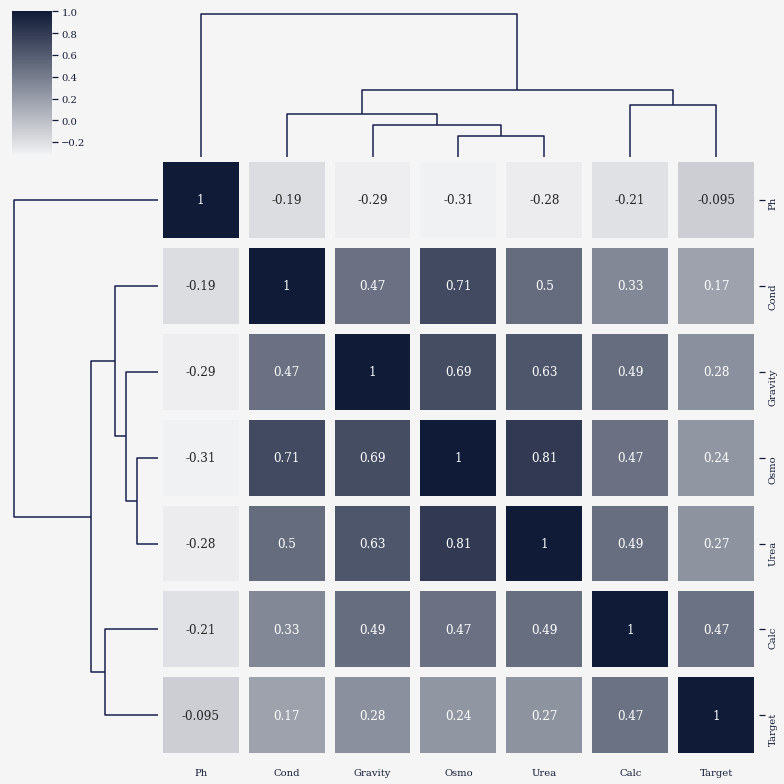

In [280]:
corr = train.corr(numeric_only=True, method="pearson")

sns.clustermap(
    corr,
    linecolor=BACKGROUND_COLOR,
    linewidth=10,
    annot=True,
    cmap=sns.light_palette("#101B37", as_cmap=True),
    tree_kws={"linewidths": 1.5, "color": "#141B4D"},
    annot_kws={"fontsize": 12},
    figsize=(11, 11),
)
plt.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>The most important for us is obviously <code>Target</code>. We can see it correlates quite well with <code>Calc</code>. The correlation coefficient is around $0.47$.</li>
    <li>There we have at least four interesting pairs yet - <code>Cond</code> vs <code>Osmo</code> ($0.71$), <code>Gravity</code> vs <code>Osmo</code> ($0.69$), <code>Gravity</code> vs <code>Urea</code> ($0.63$) and <code>Osmo</code> vs <code>Urea</code> ($0.81$) (the highest correlation coefficient at all).
    <li>Let's see these correlations over pair plots.</li>
</ul>

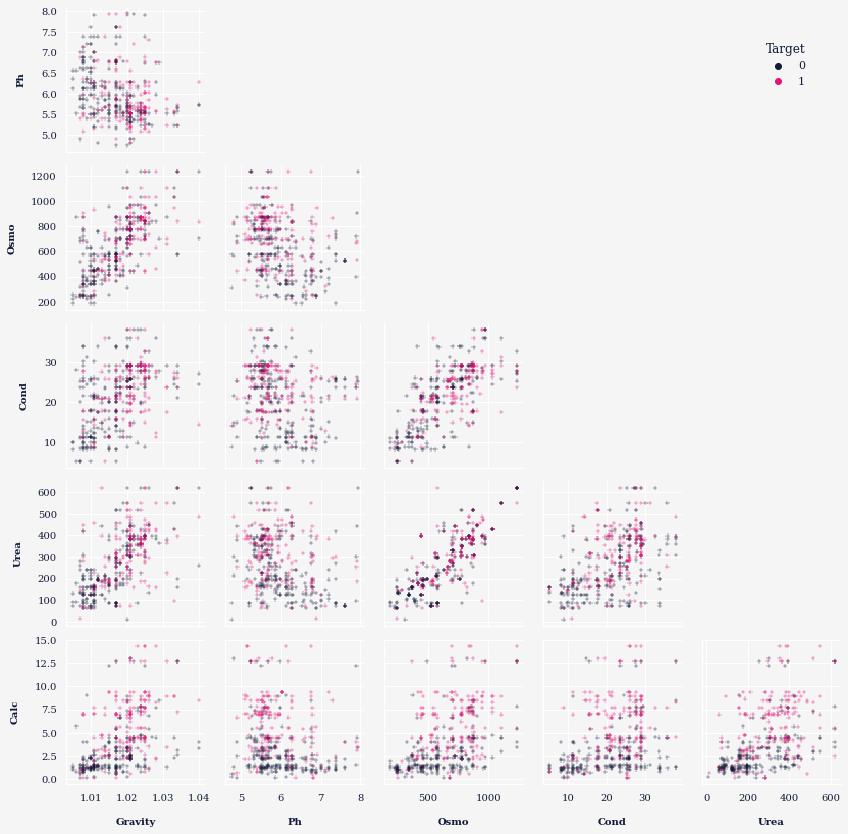

In [281]:
grid = sns.PairGrid(
    train,
    vars=train.columns.drop("Target"),
    diag_sharey=False,
    corner=True,
    hue="Target",
    palette={
        0: "#101B37",
        1: "#E41376",
    }
)

grid.fig.set_facecolor(BACKGROUND_COLOR)
grid.fig.set_size_inches(13.5, 13.5)
grid.map_lower(sns.scatterplot, marker="+", s=20)
grid.add_legend()
sns.move_legend(grid, "upper right", bbox_to_anchor=(0.77, 0.8))
for i, y_var in enumerate(grid.y_vars):
    for j, x_var in enumerate(grid.x_vars):
        if x_var == y_var:
            grid.axes[i, j].set_visible(False)  # type: ignore

plt.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>Here we have clearly visible linear dependency between <code>Cond</code> vs <code>Osmo</code> ($0.71$) and <code>Osmo</code> vs <code>Urea</code> ($0.81$), as we have read from the clustermap.</li>
    <li>Let's see distributions regarding target value.</li>
</ul>

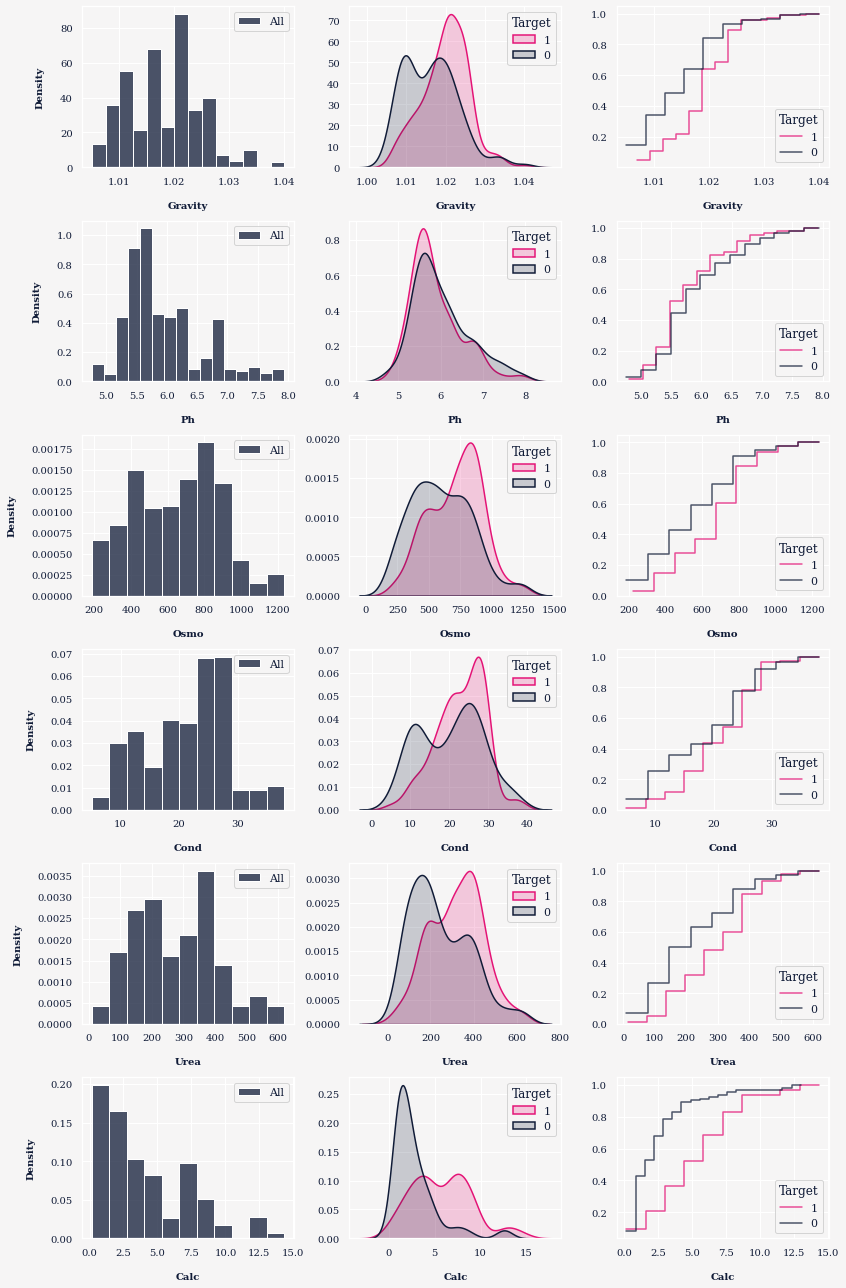

In [282]:
target_true = train["Target"] == 1
features = ["Gravity", "Ph", "Osmo", "Cond", "Urea", "Calc"]

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(11.7, 18), tight_layout=True)
kde_kw = dict(fill=True, linewidth=1.5, alpha=0.2)
hist_kw = dict(
    linewidth=1.5,
    alpha=0.75,
    element="step",
    fill=False,
    cumulative=True,
    stat="density",
)

for feature, ax in zip(features, axes):
    full = train[feature]
    target1 = train.loc[target_true, feature]
    target0 = train.loc[~target_true, feature]

    plt.sca(ax[0])
    sns.histplot(x=full, color="#101B37", stat="density", label="All", alpha=0.75)
    plt.legend(loc="upper right")

    plt.sca(ax[1])
    sns.kdeplot(x=target1, color="#E41376", label="1", **kde_kw)
    sns.kdeplot(x=target0, color="#101B37", label="0", **kde_kw)
    plt.ylabel("")
    plt.legend(loc="upper right", title="Target")

    plt.sca(ax[2])

    sns.histplot(x=target1, color="#E41376", label="1", **hist_kw)
    sns.histplot(x=target0, color="#101B37", label="0", **hist_kw)
    plt.legend(loc="lower right", title="Target")
    plt.ylabel("")

plt.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>It is visible that distributions are different regarding kidney presence (target). The significant difference is present in <code>Calc</code> feature. As we remember, this attribute has the highest correlation with the target ($0.47$).</li>
    <li>On the other hand, the <code>Ph</code> distribution is almost the same in both cases.</li>
</ul>

# <p style="padding: 15px; background-color: #101B37; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #F2F2F0; letter-spacing: 2px; text-align: center; border-radius: 8px;">Distributions &amp; Pivot Tables</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>In this section, we will take a closer look at each feature and create pivot tables which answer the question of which values are more related to the target.</li>
    <li>But let's see the target first.</li>
</ul>

In [283]:
df = train.copy()
df["Target"] = df["Target"].map({0: "False", 1: "True"})

fig = px.pie(
    df,
    names="Target",
    height=540,
    width=840,
    hole=0.65,
    title="Target Overview",
    color_discrete_sequence=["#101B37", "#E41376"],
)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    showlegend=False,
)
fig.add_annotation(
    dict(
        x=0.5,
        y=0.5,
        align="center",
        xref="paper",
        yref="paper",
        showarrow=False,
        font_size=22,
        text="Kidney Stones<br>Presence",
    )
)
fig.update_traces(
    hovertemplate=None,
    textposition="outside",
    texttemplate="%{label}<br>%{value} - %{percent}",
    textfont_size=16,
    rotation=50,
    marker_line_width=15,
    marker_line_color=BACKGROUND_COLOR,
)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>Fair enough.</li>
</ul>

In [284]:
fig = px.histogram(
    train,
    x="Gravity",
    color="Target",
    color_discrete_sequence=["#101B37", "#E41376"],
    marginal="box",
    barmode="group",
    hover_data=train.columns,
    height=540,
    width=840,
    title="Gravity vs Target",
)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    bargap=0.2,
    bargroupgap=0.1,
)
fig.update_traces(opacity=0.75)
fig.show()


In [285]:
agg_func_mapper = {
    "mean": "Mean Kidney Stones Presence",
    "sum": "Samples With Kidney",
    "count": "Samples Total",
}

gravity_pivot = (
    train.pivot_table(
        values="Target",
        index=pd.qcut(train["Gravity"], 10),
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name="Total",
    )
    .rename(
        columns=agg_func_mapper,
    )
    .droplevel(level=1, axis="columns")
    .style.background_gradient(DF_CMAP)
    .format(precision=3)
)

gravity_pivot


,Mean Kidney Stones Presence,Samples With Kidney,Samples Total
Gravity,,,
"(1.004, 1.008]",0.209,9,43
"(1.008, 1.011]",0.196,11,56
"(1.011, 1.014]",0.452,14,31
"(1.014, 1.017]",0.386,27,70
"(1.017, 1.018]",0.429,6,14
"(1.018, 1.02]",0.415,17,41
"(1.02, 1.021]",0.667,34,51
"(1.021, 1.024]",0.581,25,43
"(1.024, 1.025]",0.733,22,30


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>Generally, the higher the <code>Gravity</code>, the higher chance of kidney stones presence.</li>
</ul>

In [286]:
fig = px.histogram(
    train,
    x="Ph",
    color="Target",
    color_discrete_sequence=["#101B37", "#E41376"],
    marginal="box",
    barmode="group",
    hover_data=train.columns,
    height=540,
    width=840,
    title="Ph vs Target",
)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    bargap=0.2,
    bargroupgap=0.1,
)
fig.update_traces(opacity=0.75)
fig.show()


In [287]:
ph_pivot = (
    train.pivot_table(
        values="Target",
        index=pd.qcut(train["Ph"], 10, precision=2),
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name="Total",
    )
    .rename(
        columns=agg_func_mapper,
    )
    .droplevel(level=1, axis="columns")
    .style.background_gradient(DF_CMAP)
    .format(precision=3)
)

ph_pivot


,Mean Kidney Stones Presence,Samples With Kidney,Samples Total
Ph,,,
"(4.75, 5.33]",0.478,22,46
"(5.33, 5.51]",0.489,22,45
"(5.51, 5.53]",0.500,17,34
"(5.53, 5.66]",0.532,25,47
"(5.66, 5.74]",0.462,18,39
"(5.74, 5.94]",0.421,16,38
"(5.94, 6.19]",0.375,18,48
"(6.19, 6.43]",0.441,15,34
"(6.43, 6.81]",0.442,19,43


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>Regarding <code>Ph</code>, it's hard to say whether lower or higher values are related to kidney presence.</li>
</ul>

In [288]:
fig = px.histogram(
    train,
    x="Osmo",
    color="Target",
    color_discrete_sequence=["#101B37", "#E41376"],
    marginal="box",
    barmode="group",
    hover_data=train.columns,
    height=540,
    width=840,
    title="Osmo vs Target",
)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    bargap=0.2,
    bargroupgap=0.1,
)
fig.update_traces(opacity=0.75)
fig.show()

In [289]:
osmo_pivot = (
    train.pivot_table(
        values="Target",
        index=pd.qcut(train["Osmo"], 10),
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name="Total",
    )
    .rename(
        columns=agg_func_mapper,
    )
    .droplevel(level=1, axis="columns")
    .style.background_gradient(DF_CMAP)
    .format(precision=3)
)

osmo_pivot


,Mean Kidney Stones Presence,Samples With Kidney,Samples Total
Osmo,,,
"(186.999, 343.6]",0.143,6,42
"(343.6, 442.0]",0.391,18,46
"(442.0, 487.0]",0.316,12,38
"(487.0, 577.0]",0.393,22,56
"(577.0, 679.5]",0.400,10,25
"(679.5, 724.2]",0.512,21,41
"(724.2, 781.0]",0.478,22,46
"(781.0, 866.0]",0.590,23,39
"(866.0, 925.2]",0.667,26,39


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>In the case of <code>Osmo</code>, the issue is similar to the <code>Gravity</code>, i.e. the higher the <code>Osmo</code>, the higher chance of kidney stones presence.</li>
</ul>

In [290]:
fig = px.histogram(
    train,
    x="Cond",
    color="Target",
    color_discrete_sequence=["#101B37", "#E41376"],
    marginal="box",
    barmode="group",
    hover_data=train.columns,
    height=540,
    width=840,
    title="Cond vs Target",
)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    bargap=0.2,
    bargroupgap=0.1,
)
fig.update_traces(opacity=0.75)
fig.show()

In [291]:
cond_pivot = (
    train.pivot_table(
        values="Target",
        index=pd.qcut(train["Cond"], 10, precision=2),
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name="Total",
    )
    .rename(
        columns=agg_func_mapper,
    )
    .droplevel(level=1, axis="columns")
    .style.background_gradient(DF_CMAP)
    .format(precision=3)
)

cond_pivot


,Mean Kidney Stones Presence,Samples With Kidney,Samples Total
Cond,,,
"(5.09, 10.9]",0.159,7,44
"(10.9, 13.76]",0.205,8,39
"(13.76, 17.7]",0.467,21,45
"(17.7, 20.8]",0.652,30,46
"(20.8, 22.2]",0.528,19,36
"(22.2, 24.5]",0.385,15,39
"(24.5, 26.0]",0.400,18,45
"(26.0, 27.9]",0.650,26,40
"(27.9, 29.0]",0.644,29,45


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>In the case of <code>Cond</code>, the issue is rather mixed.</li>
</ul>

In [292]:
fig = px.histogram(
    train,
    x="Urea",
    color="Target",
    color_discrete_sequence=["#101B37", "#E41376"],
    marginal="box",
    barmode="group",
    hover_data=train.columns,
    height=540,
    width=840,
    title="Urea vs Target",
)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    bargap=0.2,
    bargroupgap=0.1,
)
fig.update_traces(opacity=0.75)
fig.show()

In [293]:
urea_pivot = (
    train.pivot_table(
        values="Target",
        index=pd.qcut(train["Urea"], 10),
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name="Total",
    )
    .rename(
        columns=agg_func_mapper,
    )
    .droplevel(level=1, axis="columns")
    .style.background_gradient(DF_CMAP)
    .format(precision=3)
)

urea_pivot


,Mean Kidney Stones Presence,Samples With Kidney,Samples Total
Urea,,,
"(9.999, 95.0]",0.182,8,44
"(95.0, 159.0]",0.216,11,51
"(159.0, 187.0]",0.485,16,33
"(187.0, 214.0]",0.286,12,42
"(214.0, 277.0]",0.405,15,37
"(277.0, 315.8]",0.659,27,41
"(315.8, 380.0]",0.511,24,47
"(380.0, 395.0]",0.575,23,40
"(395.0, 443.0]",0.605,23,38


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>Regarding <code>Urea</code>, it's clearly visible that the higher the <code>Urea</code>, the higher chance of kidney stones presence.</li>
</ul>

In [294]:
fig = px.histogram(
    train,
    x="Calc",
    color="Target",
    color_discrete_sequence=["#101B37", "#E41376"],
    marginal="box",
    barmode="group",
    hover_data=train.columns,
    height=540,
    width=840,
    title="Calc vs Target",
)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    bargap=0.2,
    bargroupgap=0.1,
)
fig.update_traces(opacity=0.75)
fig.show()

In [295]:
calc_pivot = (
    train.pivot_table(
        values="Target",
        index=pd.qcut(train["Calc"], 10),
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name="Total",
    )
    .rename(
        columns=agg_func_mapper,
    )
    .droplevel(level=1, axis="columns")
    .style.background_gradient(DF_CMAP)
    .format(precision=3)
)

calc_pivot


,Mean Kidney Stones Presence,Samples With Kidney,Samples Total
Calc,,,
"(0.169, 1.053]",0.262,11,42
"(1.053, 1.27]",0.078,4,51
"(1.27, 1.548]",0.065,2,31
"(1.548, 2.336]",0.238,10,42
"(2.336, 3.13]",0.390,16,41
"(3.13, 3.98]",0.429,18,42
"(3.98, 4.74]",0.605,26,43
"(4.74, 6.99]",0.805,33,41
"(6.99, 8.515]",0.795,31,39


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>The difference is the most visible in the case of <code>Calc</code>. Also, the correlation coefficient is the highest here, as we remember.</li>
    <li>The <code>Calc</code> and <code>Gravity</code> have the highest correlation with the target, so let's look at the multilevel pivot table yet.</li>
</ul>

In [296]:
calc_pivot = (
    train.pivot_table(
        values="Target",
        index=(
            pd.qcut(train["Calc"], 4),
            pd.qcut(train["Gravity"], 4),
        ),
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name="Total",
    )
    .rename(
        columns=agg_func_mapper,
    )
    .droplevel(level=1, axis="columns")
    .style.background_gradient(DF_CMAP)
    .format(precision=3)
)

calc_pivot


# <p style="padding: 15px; background-color: #101B37; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #F2F2F0; letter-spacing: 2px; text-align: center; border-radius: 8px;">Probability Plots</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>In this section, we will create probability plots. It's a useful tool to see whether given values come from the normal distribution (or from another specified).</li>
</ul>

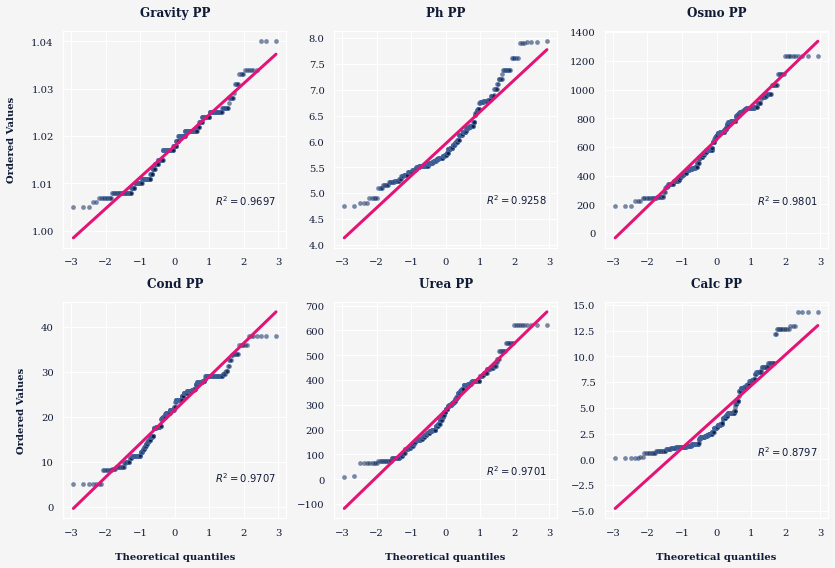

In [297]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    nrows=2, ncols=3, figsize=(11.7, 8), tight_layout=True
)

for ax, feature in zip((ax1, ax2, ax3, ax4, ax5, ax6), features):
    probplot(train[feature], plot=ax, rvalue=True)
    plt.sca(ax)
    plt.title(f"{feature} PP", fontsize=12)
    if ax not in (ax1, ax4):
        plt.ylabel("")
    if ax in (ax1, ax2, ax3):
        plt.xlabel("")

    ax.get_lines()[0].set_markerfacecolor("#101B37")
    ax.get_lines()[0].set_markersize(4.0)
    ax.get_lines()[0].set_alpha(0.5)
    ax.get_lines()[1].set_linewidth(3.0)
    ax.get_lines()[1].set_color("#E41376")

plt.show()


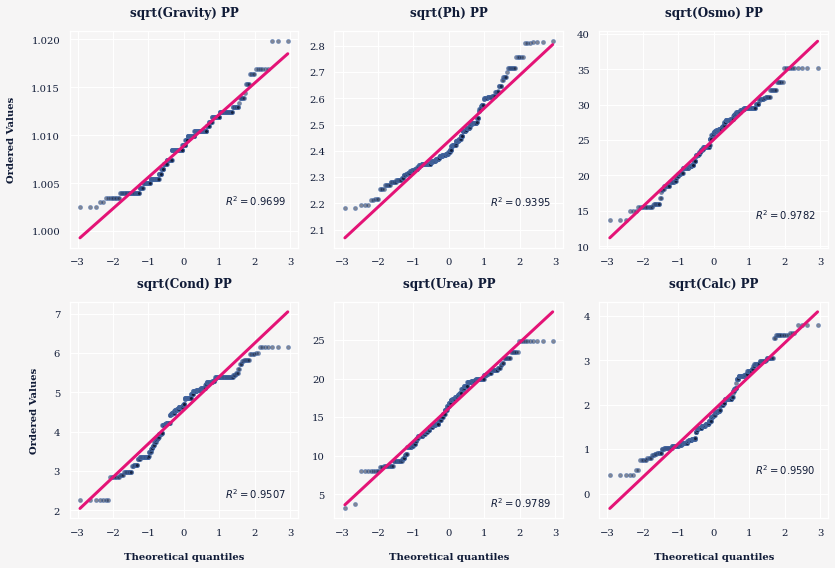

In [298]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(
    nrows=2, ncols=3, figsize=(11.7, 8), tight_layout=True
)

for ax, feature in zip((ax1, ax2, ax3, ax4, ax5, ax6), features):
    probplot(np.sqrt(train[feature]), plot=ax, rvalue=True)
    plt.sca(ax)
    plt.title(f"sqrt({feature}) PP", fontsize=12)
    if ax not in (ax1, ax4):
        plt.ylabel("")
    if ax in (ax1, ax2, ax3):
        plt.xlabel("")

    ax.get_lines()[0].set_markerfacecolor("#101B37")
    ax.get_lines()[0].set_markersize(4.0)
    ax.get_lines()[0].set_alpha(0.5)
    ax.get_lines()[1].set_linewidth(3.0)
    ax.get_lines()[1].set_color("#E41376")

plt.show()

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>As we can see, almost all features fit the normal distribution, which is manifested by a high coefficient of determination (R-squared) and evenly deployed samples around the straight line.</li>
    <li>We have only one worse result - in <code>Calc</code>. As we remember, this feature correlates with the target even more than the others.</li>
    <li>We can slightly improve fit with squared-root transformation for <code>Ph</code> and <code>Urea</code>. Meanwhile, it significantly helps with <code>Calc</code>, where R-squared rises from $0.8797$ to $0.9590$. In other cases, it's not worth using that transformation since results stay the same or are slightly worse.</li>
</ul>

# <p style="padding: 15px; background-color: #101B37; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #F2F2F0; letter-spacing: 2px; text-align: center; border-radius: 8px;">3D Projection with t-SNE</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>TSNE is an excellent tool for visualizing datasets in 2D and 3D. Let's have a look whether samples are separable in 3D.</li>
</ul>

In [299]:
y = train["Target"].astype("category")
X = train.drop("Target", axis=1)

scaler = StandardScaler()
X_full = scaler.fit_transform(X)
y_full = y

tsne = TSNE(n_components=3, random_state=42, learning_rate="auto", init="pca")

X3D = tsne.fit_transform(X_full)
X3D = pd.DataFrame(X3D, columns=["x1", "x2", "x3"], index=y.index).join(y)
X3D.head().style.set_properties(**DF_PROPS).format(precision=3)


,x1,x2,x3,Target
id,,,,
0,-6.099,1.600,1.207,0
1,3.501,1.241,-1.712,0
2,-0.982,0.645,3.258,0
3,1.963,1.789,0.855,1
4,4.129,2.698,-1.819,1


In [300]:
fig = px.scatter_3d(
    data_frame=X3D,
    x="x1",
    y="x2",
    z="x3",
    symbol="Target",
    symbol_sequence=["circle", "diamond"],
    color="Target",
    color_discrete_sequence=["#101B37", "#E41376"],
    opacity=0.6,
    height=640,
    width=840,
    title="Training Dataset - 3D projection with t-SNE",
)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.update_traces(marker_size=4)
fig.show()

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>Unfortunately, they are not separable. However, we can spot something like two clusters.</li>
</ul>

# <p style="padding: 15px; background-color: #101B37; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #F2F2F0; letter-spacing: 2px; text-align: center; border-radius: 8px;">Features Importance</p>

<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>Let's see the feature importance with different methods. We'll look at how a simple decision tree makes decisions, and then we will see a more sophisticated approach with <code>LDA</code>, <code>RandomForestClassifier</code> and <code>mutual_info_classif</code>.</li>
</ul>

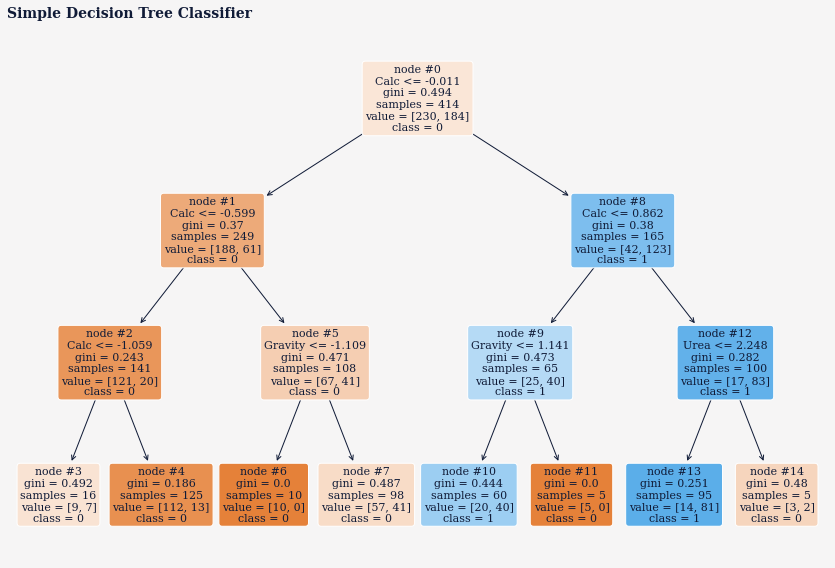

In [301]:
feature_names_out = scaler.get_feature_names_out()

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_full, y_full)
y_classes = tree_clf.classes_.astype(str)

fig, ax = plt.subplots(1, 1, figsize=(11.7, 8), tight_layout=True)
plot_tree(
    decision_tree=tree_clf,
    feature_names=feature_names_out,
    class_names=y_classes,
    filled=True,
    rounded=True,
    node_ids=True,
    impurity=True,
    ax=ax,
    fontsize=11,
)
plt.title("Simple Decision Tree Classifier", loc="left")
plt.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>As we can see, this tree decides concerning <code>Calc</code>, <code>Gravity</code> and <code>Urea</code>. This should not surprise us too much since these features have the highest correlation with the target.</li>
    <li>Now let's have a look at <code>LDA</code>, <code>RandomForestClassifier</code> and <code>mutual_info_classif</code>.</li>
</ul>

In [302]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_full, y_full)
lda_info = np.abs(lda.scalings_.ravel())
lda_info = lda_info / lda_info.sum()

forest = RandomForestClassifier(random_state=42)
forest.fit(X_full, y_full)
forest_info = forest.feature_importances_

mutual_info = mutual_info_classif(X_full, y_full, random_state=42)
mutual_info = mutual_info / np.sum(mutual_info)

importances = pd.DataFrame(
    [lda_info, forest_info, mutual_info],
    columns=feature_names_out,
    index=["LDA", "Random Forest", "Mutual Information"],
).T

importances = importances.loc[
    importances.mean(axis=1).sort_values(ascending=False).index
]

importances.style.background_gradient(DF_CMAP).format(precision=3)


,LDA,Random Forest,Mutual Information
Calc,0.680,0.318,0.408
Gravity,0.118,0.127,0.169
Urea,0.076,0.146,0.177
Osmo,0.081,0.118,0.114
Cond,0.016,0.138,0.132
Ph,0.030,0.154,0.000


In [303]:
melted = (
    importances.melt(
        var_name="Method",
        value_name="Importance",
        ignore_index=False,
    )
    .reset_index()
    .rename(columns={"index": "Feature"})[::-1]
)

fig = px.bar(
    data_frame=melted,
    x="Importance",
    y="Feature",
    color="Method",
    barmode="group",
    height=540,
    width=840,
    color_discrete_sequence=px.colors.sequential.Bluyl_r,
    title="Normalised Feature Importances",
)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    bargroupgap=0.1,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>As you see, different methods give different results, but the general trend is undoubtedly visible. According to all methods, the <code>Calc</code> feature is the most important.</li>
    <li>Let's stay with the feature importance problem and see how the AUC of <code>RandomForestClassifier</code> changes when we randomly permute samples in a specific attribute since random permutation of variable results in removing all predictive power for this attribute.</li>
</ul>

In [304]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
forest = RandomForestClassifier(random_state=42)
auc_scores = defaultdict(list)
np.random.seed(42)

for k, (train_ids, valid_ids) in enumerate(skfold.split(X, y)):

    X_train, y_train = X.iloc[train_ids], y.iloc[train_ids]
    X_valid, y_valid = X.iloc[valid_ids], y.iloc[valid_ids]

    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)

    forest.fit(X_train, y_train)
    auc = roc_auc_score(y_valid, forest.predict_proba(X_valid)[:, 1])

    for i, feature in enumerate(feature_names_out):
        X_shuffled = X_valid.copy()
        X_shuffled[:, i] = np.random.permutation(X_shuffled[:, i])
        auc_shuffled = roc_auc_score(y_valid, forest.predict_proba(X_shuffled)[:, 1])
        auc_scores[feature].append((auc - auc_shuffled) / auc)

    print(CLR + "Fold:", f"{RED}{1 + k:02}", f"\t{CLR}Baseline AUC: {RED}{auc:.3f}")


Fold: 01 	Baseline AUC: 0.713
Fold: 02 	Baseline AUC: 0.705
Fold: 03 	Baseline AUC: 0.828
Fold: 04 	Baseline AUC: 0.828
Fold: 05 	Baseline AUC: 0.833
Fold: 06 	Baseline AUC: 0.849
Fold: 07 	Baseline AUC: 0.838
Fold: 08 	Baseline AUC: 0.781
Fold: 09 	Baseline AUC: 0.773
Fold: 10 	Baseline AUC: 0.835


In [305]:
auc_decrease_df = (
    pd.DataFrame(auc_scores)
    .mean()
    .sort_values()
    .to_frame(name="Mean AUC Decrease")
    .reset_index()
    .rename(columns={"index": "Feature"})
)

fig = px.bar(
    data_frame=auc_decrease_df,
    x="Mean AUC Decrease",
    y="Feature",
    height=540,
    width=840,
    color="Mean AUC Decrease",
    color_continuous_scale=px.colors.sequential.Bluyl,
    title="Random Forest - Mean AUC Decrease within Samples Permutation",
)
fig.update_layout(
    font_color=FONT_COLOR,
    title_font_size=18,
    bargap=0.3,
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>The result is huge, as you can see. Random permutation of samples in <code>Calc</code> leads to a vast AUC decrease. Meanwhile, in other features, the outcome is negligible.</li>
    <li>Moreover, this method is based on out-of-bag data, so it is more accurate than the Gini impurity decrease.</li>
    <li>Let's see at partial dependence plots yet.</li>
</ul>

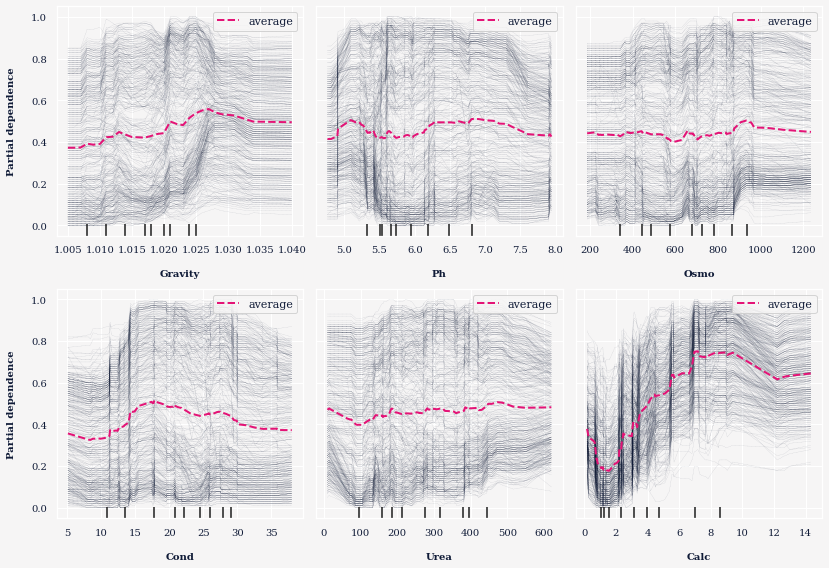

In [306]:
forest = RandomForestClassifier(random_state=42)
forest.fit(X, y)

fig, axes = plt.subplots(2, 3, figsize=(11.7, 8), tight_layout=True, sharey=True)

PartialDependenceDisplay.from_estimator(
    forest,
    X,
    features,
    response_method="predict_proba",
    kind="both",
    percentiles=(0, 1),
    ice_lines_kw={
        "color": "#101B37",
        "linewidth": 0.25,
        "alpha": 0.25,
        "linestyle": "--",
    },
    pd_line_kw={"color": "#E41376", "linewidth": 2.0},
    ax=axes.ravel(),
)

for ax in axes.ravel():
    ax.legend(loc="upper right")
    if ax not in (axes[0, 0], axes[1, 0]):
        ax.set_ylabel("")

plt.show()


<p style="
    font-size: 20px;
    font-family: 'JetBrains Mono';
    border-bottom: 3px solid #01CBEE;
">
    <b>Notes</b> 📜
</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>In general partial dependence plot (PDP) is another tool for visualizing the feature's importance. However, this approach differs slightly from the earlier depicted. Here, the partial dependence plot shows the relationship between the model outcome and a particular feature. In this case, the outcome (partial dependence) is a probability of positive class.</li>
    <li>Actually, we've created individual conditional expectation (ICE) plots. It's similar to PDP, but here ICE plot shows the dependency of the prediction
within a given feature for each sample (it means each black line corresponds to a specific sample).</li>
    <li>So, what can we see here? Obviously, the <code>Calc</code> stole the whole show. Positive class probability strongly depends on this feature and, in the range $(2.5, 7.5)$ of <code>Calc</code>, the outcome "linearly" grows. On the other hand, the remaining attributes don't have such predictive power. Maybe only the <code>Gravity</code> and <code>Cond</code> are slightly important yet.</li>
</ul>

# <p style="padding: 15px; background-color: #101B37; font-family: 'JetBrains Mono'; font-weight: bold; font-size: 100%; color: #F2F2F0; letter-spacing: 2px; text-align: center; border-radius: 8px;">Summary</p>

<ul style="
    font-size: 16px;
    font-family: 'JetBrains Mono';
    margin-left: 8px;
    margin-right: 8px;
">
    <li>There we have only $414$ samples with six numerical features and binary target.</li>
    <li>There are no missing values and no imputation is needed.</li>
    <li>The target balance is fair enough ($44$% - $56$%).
    <li>The target is mostly correlated with the <code>Calc</code> ($0.47$).</li>
    <li>We have four highly correlated pairs - <code>Cond</code> vs <code>Osmo</code> ($0.71$), <code>Gravity</code> vs <code>Osmo</code> ($0.69$), <code>Gravity</code> vs <code>Urea</code> ($0.63$) and <code>Osmo</code> vs <code>Urea</code> ($0.81$).
    <li>Features fit the normal distribution (high R-squared, usually $>0.90$).</li>
     <li>It's reasonable to transform <code>Calc</code> with a square root. It improves the fit to the normal distribution and R-squared coefficient from $0.8797$ to $0.9590$</li>
    <li>Samples are not easily separable in 3D.</li>
    <li>Feature importance measures make it clear that there is only one relevant attribute - <code>Calc</code>.</li>
    <li>If you like my work and visualisations, then upvote. I appreciate that. Moreover, you can look over my other notebooks. Maybe you find something useful there.</li>
</ul>